## Multivariate Data Analysis Project
### Predict Calorie Value
### Ashima Munjal - amunjal@stevens.edu - 10455515

#### Loading Dependencies.

In [1]:
# Data Processing Libraries.
import pandas as pd

# Machine Learning Libraries.
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LassoLarsIC, LassoCV
from sklearn.preprocessing import MinMaxScaler 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Evaluation Libraries.
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

# Visualization Libraries.
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#### Loading data.

In [2]:
food_data = pd.read_excel("Food_Display_Table.xlsx")
print("Variables in the data:",
      "\n", list(food_data.columns))

Variables in the data: 
 ['Food_Code', 'Display_Name', 'Portion_Default', 'Portion_Amount', 'Portion_Display_Name', 'Factor', 'Increment', 'Multiplier', 'Grains', 'Whole_Grains', 'Vegetables', 'Orange_Vegetables', 'Drkgreen_Vegetables', 'Starchy_vegetables', 'Other_Vegetables', 'Fruits', 'Milk', 'Meats', 'Soy', 'Drybeans_Peas', 'Oils', 'Solid_Fats', 'Added_Sugars', 'Alcohol', 'Calories', 'Saturated_Fats']


#### Visualizing dataset.

In [3]:
print(food_data.shape)
food_data.head()

(2014, 26)


,Food_Code,Display_Name,Portion_Default,Portion_Amount,Portion_Display_Name,Factor,Increment,Multiplier,Grains,Whole_Grains,...,Milk,Meats,Soy,Drybeans_Peas,Oils,Solid_Fats,Added_Sugars,Alcohol,Calories,Saturated_Fats
0,12350000,Sour cream dip,1,0.25,cup,0.25,0.25,1.00,0.04799,0.0,...,0.00000,0.0000,0.0,0.0,0.0,105.64850,1.57001,0.0,133.65,7.36898
1,13110100,"Ice cream, regular",1,1.00,cup,1.00,0.25,0.25,0.00000,0.0,...,0.29393,0.0000,0.0,0.0,0.0,130.99968,95.20488,0.0,267.33,9.03070
2,13110120,"Ice cream, rich",1,1.00,cup,1.00,0.25,0.25,0.00000,0.0,...,0.25160,0.0962,0.0,0.0,0.0,213.06672,96.10340,0.0,368.52,15.28840
3,13110200,Soft serve ice cream,1,1.00,cup,1.00,0.25,0.25,0.00000,0.0,...,0.38233,0.0000,0.0,0.0,0.0,170.39808,123.83793,0.0,347.73,11.74670
4,13120100,"Ice cream bar, chocolate covered",1,1.00,bar (bar = 3 fl oz),1.00,0.50,0.50,0.00000,0.0,...,0.09744,0.0000,0.0,0.0,0.0,112.32144,45.54761,0.0,169.12,9.58720


### Exploratory Data Analysis.

#### Observing distribution of Target Variable(Calorie) in the data.

In [4]:
max_cal = np.max(food_data["Calories"].values)
min_cal = np.min(food_data["Calories"].values)

frequency, bins = np.histogram(food_data["Calories"].values, bins=20, range=[min_cal, max_cal])
print("Calorie bins:",
     "\n",bins)

Calorie bins: 
 [   0.     83.37  166.74  250.11  333.48  416.85  500.22  583.59  666.96
  750.33  833.7   917.07 1000.44 1083.81 1167.18 1250.55 1333.92 1417.29
 1500.66 1584.03 1667.4 ]


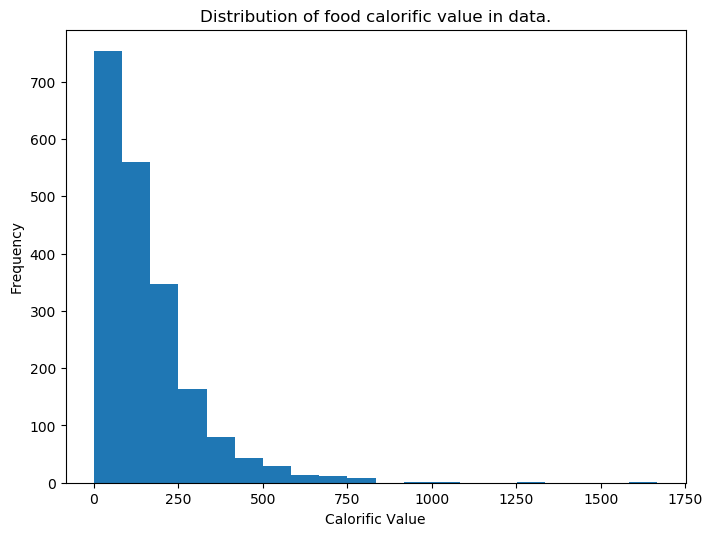

In [5]:
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':100})

# Plot Histogram of Calorie Distribution in the data.
plt.hist(food_data["Calories"].values, bins=bins)
plt.gca().set(title='Distribution of food calorific value in data.', xlabel="Calorific Value", ylabel='Frequency');


#### Binning target variable using Equal-Width binning.

In [6]:
max_cal = np.max(food_data["Calories"].values)
min_cal = np.min(food_data["Calories"].values)
number_of_bins = 4
bin_size = (max_cal - min_cal)/number_of_bins
print("Bin size used for making categories:", bin_size)

Bin size used for making categories: 416.85


#### Creating Categorical Variable.

In [7]:
range_ = [0]
for ele in range(number_of_bins-1):
    range_.append(range_[ele] + bin_size)

In [8]:
calorie_category = []
for ele in food_data["Calories"].values:
    if ele > range_[0] and ele < range_[1]:
        calorie_category.append(["Very Low"])
    elif ele > range_[1] and ele < range_[2]:
        calorie_category.append(["Low"])
    elif ele > range_[2] and ele < range_[3]:
        calorie_category.append(["High"])
    else:
        calorie_category.append(["Very High"])
calorie_category = [ele[0]for ele in calorie_category]

In [9]:
pd.Series(calorie_category).value_counts()

Very Low     1899
Low           106
Very High       6
High            3
dtype: int64

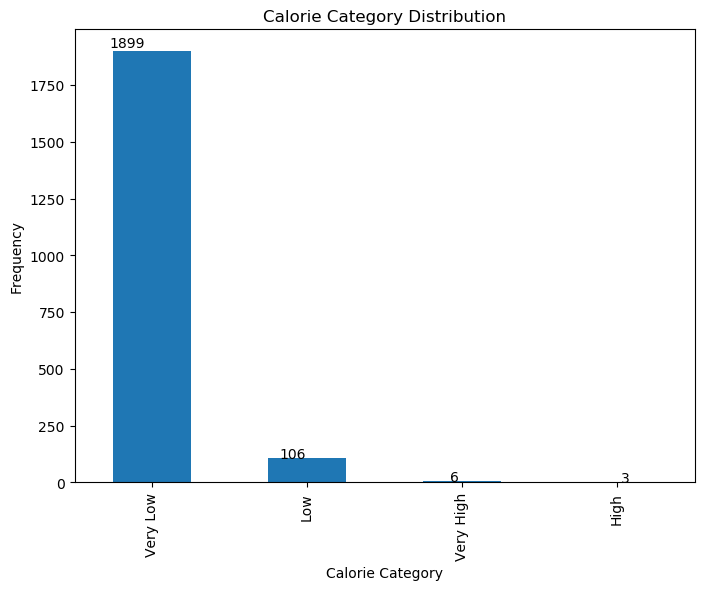

In [10]:
cal_dist = pd.Series(calorie_category).value_counts().plot(kind="bar",title='Calorie Category Distribution')
cal_dist.set_xlabel("Calorie Category")
cal_dist.set_ylabel("Frequency")
for p in cal_dist.patches:
    cal_dist.annotate(str(p.get_height()), (p.get_x()*1.1, p.get_height()*1.01));

#### Creating categories based on accepted measures for calorie distribution.
- Low Calorie = Calorie < 40
- Medium Calorie = 40 > Calorie < 100
- High Calorie = Calorie > 100

In [11]:
range_ = [0, 40, 100]
calorie_category = []
for ele in food_data["Calories"].values:
    if ele > range_[0] and ele < range_[1]:
        calorie_category.append(["Low"])
    elif ele > range_[1] and ele < range_[2]:
        calorie_category.append(["Medium"])
    else:
        calorie_category.append(["High"])
calorie_category = [ele[0]for ele in calorie_category]

In [12]:
pd.Series(calorie_category).value_counts()

High      1140
Medium     507
Low        367
dtype: int64

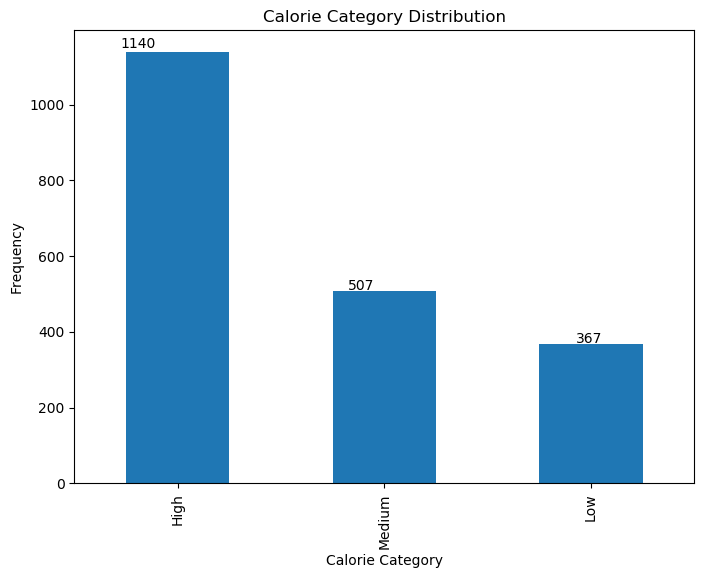

In [13]:
cal_dist = pd.Series(calorie_category).value_counts().plot(kind="bar",title='Calorie Category Distribution')
cal_dist.set_xlabel("Calorie Category")
cal_dist.set_ylabel("Frequency")
for p in cal_dist.patches:
    cal_dist.annotate(str(p.get_height()), (p.get_x()*1.1, p.get_height()*1.01));

#### Verifying data Integrity.

In [14]:
assert len(calorie_category)==len(food_data["Calories"].values)

#### Analysis -
#### From the graphs above we can observe that using a mathematical approach(Equal-Width Binning) to decide bin value could make the data very skewed. However, when we created bins based on the most common boundaries set by professionals in the field, we could make a very even distribution.

#### Correlation Map.

In [15]:
id_cols = ["Food_Code", "Display_Name", "Portion_Display_Name"]
similar_cols = ["Portion_Amount", "Factor",
                "Increment", "Multiplier",
                "Portion_Default"]
drp_cols = id_cols + similar_cols

In [16]:
ml_pipeline_data = food_data.drop(drp_cols, axis=1)
print(ml_pipeline_data.shape)
ml_pipeline_data.head()

(2014, 18)


,Grains,Whole_Grains,Vegetables,Orange_Vegetables,Drkgreen_Vegetables,Starchy_vegetables,Other_Vegetables,Fruits,Milk,Meats,Soy,Drybeans_Peas,Oils,Solid_Fats,Added_Sugars,Alcohol,Calories,Saturated_Fats
0,0.04799,0.0,0.0407,0.0,0.0,0.0,0.0407,0.0,0.00000,0.0000,0.0,0.0,0.0,105.64850,1.57001,0.0,133.65,7.36898
1,0.00000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.29393,0.0000,0.0,0.0,0.0,130.99968,95.20488,0.0,267.33,9.03070
2,0.00000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.25160,0.0962,0.0,0.0,0.0,213.06672,96.10340,0.0,368.52,15.28840
3,0.00000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.38233,0.0000,0.0,0.0,0.0,170.39808,123.83793,0.0,347.73,11.74670
4,0.00000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.09744,0.0000,0.0,0.0,0.0,112.32144,45.54761,0.0,169.12,9.58720


In [17]:
summary_stats = ml_pipeline_data.describe()
summary_stats.to_excel("EDA_Food_Data.xlsx")

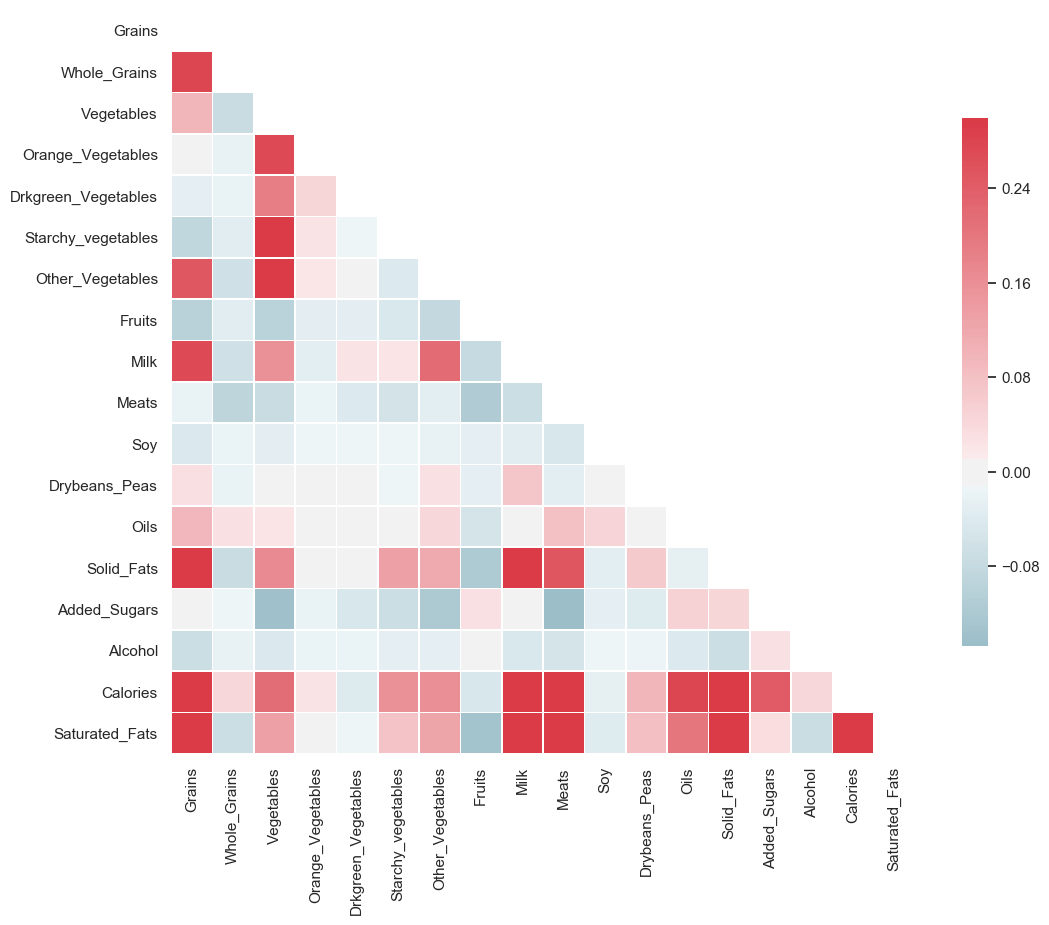

In [18]:
# Visualizing correlation will be more absolute using standard scaler.
col = list(ml_pipeline_data.keys())[:-1]
scaler = MinMaxScaler()
ml_pipeline_data[col] = scaler.fit_transform(ml_pipeline_data[col])

sns.set(style="white")

# Compute the correlation matrix.
pearson_corr = ml_pipeline_data.corr(method ='pearson')

# Generate a mask for the upper triangle.
mask = np.zeros_like(pearson_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 14))

# Generate a custom diverging colormap.
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio.
sns.heatmap(pearson_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Regression Analysis.

### Target Variable - Continuous (Calorie Value)

#### Selecting the independent and dependent variables from dataframe.

In [19]:
ml_pipeline_data = food_data.drop(drp_cols, axis=1)
print(ml_pipeline_data.shape)
ml_pipeline_data.head()

(2014, 18)


,Grains,Whole_Grains,Vegetables,Orange_Vegetables,Drkgreen_Vegetables,Starchy_vegetables,Other_Vegetables,Fruits,Milk,Meats,Soy,Drybeans_Peas,Oils,Solid_Fats,Added_Sugars,Alcohol,Calories,Saturated_Fats
0,0.04799,0.0,0.0407,0.0,0.0,0.0,0.0407,0.0,0.00000,0.0000,0.0,0.0,0.0,105.64850,1.57001,0.0,133.65,7.36898
1,0.00000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.29393,0.0000,0.0,0.0,0.0,130.99968,95.20488,0.0,267.33,9.03070
2,0.00000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.25160,0.0962,0.0,0.0,0.0,213.06672,96.10340,0.0,368.52,15.28840
3,0.00000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.38233,0.0000,0.0,0.0,0.0,170.39808,123.83793,0.0,347.73,11.74670
4,0.00000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.09744,0.0000,0.0,0.0,0.0,112.32144,45.54761,0.0,169.12,9.58720


In [20]:
label = ['Calories']
predictors = ml_pipeline_data.drop(label, axis=1)
target = food_data[label[0]]

#### Applying OLS regression model.

In [21]:
predictors = sm.add_constant(predictors)
glm_model = sm.OLS(target, predictors).fit()
glm_model.summary()

/Users/ashimamunjal/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Calories   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     3002.
Date:                Wed, 11 Dec 2019   Prob (F-statistic):               0.00
Time:                        20:31:37   Log-Likelihood:                -9592.2
No. Observations:                2014   AIC:                         1.922e+04
Df Residuals:                    1996   BIC:                         1.932e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   6.9260      0.998      6.937      0.000       4.968       8.884
Grains                 63.6134      0.803     79.244      0.000      62.039      65.188
Whole_Grains            9.3381      2.517      3.710      0.000       4.402      14.274
Vegetables            143.4452    526.405      0.272      0.785    -888.915    1175.806
Orange_Vegetables     -40.1919    526.839     -0.076      0.939   -1073.404     993.020
Drkgreen_Vegetables  -107.1567    526.592     -0.203      0.839   -1139.885     925.571
Starchy_vegetables     19.1779    526.576      0.036      0.971   -1013.517    1051.873
Other_Vegetables     -107.6245    526.296     -0.204      0.838   -1139.773     924.523
Fruits                 81.8754      3.082     26.568      0.000      75.832      87.919
Milk                   46.6462      3.153     14.796      0.000      40.463      52.829
Meats                  42.4210      0.620     68.460      0.000      41.206      43.636
Soy                    40.9229      4.533      9.028      0.000      32.033      49.813
Drybeans_Peas         212.9799     12.891     16.522      0.000     187.699     238.261
Oils                   28.5927      0.846     33.811      0.000      26.934      30.251
Solid_Fats              0.6478      0.024     26.701      0.000       0.600       0.695
Added_Sugars            1.0242      0.016     63.546      0.000       0.993       1.056
Alcohol                 0.9432      0.030     31.823      0.000       0.885       1.001
Saturated_Fats          9.5910      0.482     19.913      0.000       8.646      10.536
==============================================================================
Omnibus:                      532.231   Durbin-Watson:                   1.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7322.779
Skew:                           0.851   Prob(JB):                         0.00
Kurtosis:                      12.185   Cond. No.                     1.28e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Selecting LassoLarsIC Model with "bic" criterion.


In [22]:
regression = LassoLarsIC(criterion='bic')

#### Fitting the model with data.

In [23]:
regression.fit(predictors, target)

LassoLarsIC(copy_X=True, criterion='bic', eps=2.220446049250313e-16,
            fit_intercept=True, max_iter=500, normalize=True, positive=False,
            precompute='auto', verbose=False)

#### Observing the variables selected by the model.

In [24]:
selected_features = list(predictors.columns[np.abs(regression.coef_) > 0])
print("The LassoLarsIC model has selected the following features: ")
for idx, ele in enumerate(selected_features):
    print(str(idx+1), ":", ele)

The LassoLarsIC model has selected the following features: 
1 : Grains
2 : Vegetables
3 : Orange_Vegetables
4 : Starchy_vegetables
5 : Fruits
6 : Milk
7 : Meats
8 : Soy
9 : Drybeans_Peas
10 : Oils
11 : Solid_Fats
12 : Added_Sugars
13 : Alcohol
14 : Saturated_Fats


#### Splitting data into train and test sets for Machine Learning Model.

In [25]:
# Splitting data.
split = 25
random_idx = np.random.permutation(len(ml_pipeline_data))
test_size = int(len(ml_pipeline_data) * (split/100))
test_idx = random_idx[:test_size]
train_idx = random_idx[test_size:]
train_set = ml_pipeline_data.loc[train_idx]
test_set = ml_pipeline_data.loc[test_idx]

# Dropping the dependent variable in the training and testing data 
# and creating label vector using it.
# x - Predictor, y - Label.
tr_x = train_set.drop(label, axis=1)
tr_y = train_set[label]
ts_x = test_set.drop(label, axis=1)
ts_y = test_set[label].values

numeric_pipeline = Pipeline(steps=[
                    ('scaler', MinMaxScaler())])

# Transforming the dataset.
tr_x = numeric_pipeline.fit_transform(tr_x)
ts_x = numeric_pipeline.transform(ts_x)

# Rows of data in the training and testing set after transformation.
print("\nTraining Predictor Shape: {0}".format(tr_x.shape))
print("Testing Predictor Shape: {0}".format(ts_x.shape))

tr_y = np.asarray(tr_y)
tr_y = tr_y.reshape(-1,1)
tr_y = numeric_pipeline.fit_transform(tr_y)

print("\nTraining Label Shape: {0}".format(tr_y.shape))
print("Testing Label Shape: {0}".format(ts_y.shape))


Training Predictor Shape: (1511, 17)
Testing Predictor Shape: (503, 17)

Training Label Shape: (1511, 1)
Testing Label Shape: (503, 1)


#### Selecting LassoLarsIC Model.

In [26]:
regression = LassoLarsIC()

#### Fitting the model with scaled data.

In [27]:
regression.fit(tr_x, tr_y)

/Users/ashimamunjal/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoLarsIC(copy_X=True, criterion='aic', eps=2.220446049250313e-16,
            fit_intercept=True, max_iter=500, normalize=True, positive=False,
            precompute='auto', verbose=False)

#### Predicting the results.

In [28]:
prediction_lassolars = regression.predict(ts_x)
prediction_lassolars = numeric_pipeline.inverse_transform(prediction_lassolars.reshape(-1, 1))

#### Evaluating the model using mean squared error.

In [29]:
score_lassolars = metrics.mean_squared_error(y_true=ts_y, y_pred=prediction_lassolars)
print("LassoLarsIC Performance Score:", score_lassolars)

LassoLarsIC Performance Score: 959.729666800038


#### Selecting LassoCV Model.

In [30]:
model_lasso_cv = LassoCV(cv=3, normalize=False)
model_lasso_cv.fit(tr_x, tr_y)
prediction_lassocv = model_lasso_cv.predict(ts_x)
prediction_lassocv = numeric_pipeline.inverse_transform(prediction_lassocv.reshape(-1, 1))
score_lassocv = metrics.mean_squared_error(y_true=ts_y, y_pred=prediction_lassocv)
print("LassoCV Performance Score::", score_lassocv)

LassoCV Performance Score:: 958.7587332652159


/Users/ashimamunjal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Target Variable - Categorical (Calorie Categories)

In [31]:
ml_pipeline_data = food_data.drop(drp_cols, axis=1)
print(ml_pipeline_data.shape)
ml_pipeline_data.head()

(2014, 18)


,Grains,Whole_Grains,Vegetables,Orange_Vegetables,Drkgreen_Vegetables,Starchy_vegetables,Other_Vegetables,Fruits,Milk,Meats,Soy,Drybeans_Peas,Oils,Solid_Fats,Added_Sugars,Alcohol,Calories,Saturated_Fats
0,0.04799,0.0,0.0407,0.0,0.0,0.0,0.0407,0.0,0.00000,0.0000,0.0,0.0,0.0,105.64850,1.57001,0.0,133.65,7.36898
1,0.00000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.29393,0.0000,0.0,0.0,0.0,130.99968,95.20488,0.0,267.33,9.03070
2,0.00000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.25160,0.0962,0.0,0.0,0.0,213.06672,96.10340,0.0,368.52,15.28840
3,0.00000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.38233,0.0000,0.0,0.0,0.0,170.39808,123.83793,0.0,347.73,11.74670
4,0.00000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.09744,0.0000,0.0,0.0,0.0,112.32144,45.54761,0.0,169.12,9.58720


#### Dropping continuous target variable - Calories.


In [32]:
ml_pipeline_data.drop('Calories', axis=1, inplace=True)

#### Adding categorical "Calories" variable to the data.

In [33]:
ml_pipeline_data['Calories'] = calorie_category

In [34]:
ml_pipeline_data.head()

,Grains,Whole_Grains,Vegetables,Orange_Vegetables,Drkgreen_Vegetables,Starchy_vegetables,Other_Vegetables,Fruits,Milk,Meats,Soy,Drybeans_Peas,Oils,Solid_Fats,Added_Sugars,Alcohol,Saturated_Fats,Calories
0,0.04799,0.0,0.0407,0.0,0.0,0.0,0.0407,0.0,0.00000,0.0000,0.0,0.0,0.0,105.64850,1.57001,0.0,7.36898,High
1,0.00000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.29393,0.0000,0.0,0.0,0.0,130.99968,95.20488,0.0,9.03070,High
2,0.00000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.25160,0.0962,0.0,0.0,0.0,213.06672,96.10340,0.0,15.28840,High
3,0.00000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.38233,0.0000,0.0,0.0,0.0,170.39808,123.83793,0.0,11.74670,High
4,0.00000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.09744,0.0000,0.0,0.0,0.0,112.32144,45.54761,0.0,9.58720,High


In [35]:
# Splitting data.
split = 25
random_idx = np.random.permutation(len(ml_pipeline_data))
test_size = int(len(ml_pipeline_data) * (split/100))
test_idx = random_idx[:test_size]
train_idx = random_idx[test_size:]
train_set = ml_pipeline_data.loc[train_idx]
test_set = ml_pipeline_data.loc[test_idx]

# Dropping the dependent variable in the training and testing data 
# and creating label vector using it.
# x - Predictor, y - Label.
tr_x = train_set.drop(label, axis=1)
tr_y = train_set[label]
ts_x = test_set.drop(label, axis=1)
ts_y = test_set[label].values

numeric_pipeline = Pipeline(steps=[
                    ('scaler', MinMaxScaler())])

# Transforming the dataset.
tr_x = numeric_pipeline.fit_transform(tr_x)
ts_x = numeric_pipeline.transform(ts_x)

# Rows of data in the training and testing set after transformation.
print("\nTraining Predictor Shape: {0}".format(tr_x.shape))
print("Testing Predictor Shape: {0}".format(ts_x.shape))

tr_y = np.asarray(tr_y)
tr_y = tr_y.reshape(-1,1)

print("\nTraining Label Shape: {0}".format(tr_y.shape))
print("Testing Label Shape: {0}".format(ts_y.shape))


Training Predictor Shape: (1511, 17)
Testing Predictor Shape: (503, 17)

Training Label Shape: (1511, 1)
Testing Label Shape: (503, 1)


#### Applying Random Forest Classifier.

In [36]:
rf = RandomForestClassifier()
rf.fit(tr_x, tr_y)

/Users/ashimamunjal/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ashimamunjal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Predicting the results.

In [37]:
prediction_rf = rf.predict(ts_x)

#### Evaluating the model.

In [38]:
cm = confusion_matrix(ts_y, prediction_rf)
print('Confusion Matrix:\n', cm)
print('\nClassification Report:\n', classification_report(ts_y, prediction_rf))


Confusion Matrix:
 [[262   4  16]
 [  1  79  16]
 [ 22  13  90]]

Classification Report:
               precision    recall  f1-score   support

        High       0.92      0.93      0.92       282
         Low       0.82      0.82      0.82        96
      Medium       0.74      0.72      0.73       125

    accuracy                           0.86       503
   macro avg       0.83      0.82      0.83       503
weighted avg       0.86      0.86      0.86       503



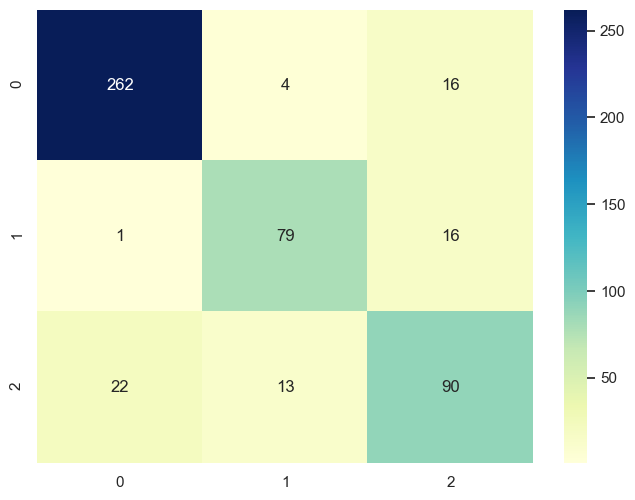

In [39]:
sns.heatmap(cm, cmap="YlGnBu", annot=True, fmt="d")